# Experimentation
---

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from utils import load_data, get_loaders

In [2]:
seed = 42

data_path = 'data/'

### Load Drivers Data

In [3]:
drivers, maneuver_names, dfs = load_data(data_path)

### Models

We are going to compare the performance of the following models:   
- Logistic Regression: A simple linear model that is used to classify binary outcomes.
- Decision Tree: A model that uses a tree-like graph of decisions and their possible consequences.

For each model type, we will select some of the most important hyperparameters and use a grid search to find the best combination of hyperparameters.

In addition, previous to the training of the models, we will preprocess the data by scaling the features. To do this, we will use a Pipeline object that will first scale the features and then train the model.



In [4]:
def instantiate_model(model_name, cv):
    """Function to instantiate a model"""

    if model_name == "logreg":
        param_grid = {'penalty':['l1','l2']}
        
        return Pipeline([
            ('scaler', StandardScaler()),  # Data normalization
            ('model', GridSearchCV(LogisticRegression(random_state=seed, solver='liblinear'),
                                    param_grid=param_grid,
                                    cv=cv,
                                    scoring='accuracy',
                                    n_jobs=-1, verbose=0))
        ])

    if model_name == "tree":
        param_grid = {'max_depth': list(range(2,10,2)),
                      'min_samples_split': list(range(2,8,2))}

        return Pipeline([
            ('scaler', StandardScaler()),  # Data normalization
            ('model', GridSearchCV(DecisionTreeClassifier(random_state=seed),
                                    param_grid, 
                                    cv=cv,
                                    scoring='accuracy',
                                    n_jobs=-1, verbose=0))
        ])

## Cross Validation 

To properly evaluate the models without introducing driver biases, it is necessary to separate training and evaluation by subjects/drivers.

However, evaluating the model with a single driver may not be sufficient for a robust assessment. Therefore, subject-wise cross-validation is performed by dividing the data into five partitions and evaluating the model on each one.

Thus, the model will be evaluated with each driver while using the remaining ones for training, and the average of the results will be calculated as the model's final performance.

![image.png](https://miro.medium.com/v2/resize:fit:1400/1*5CYtLwuXE7bEFkW7D-1ENg.png)

In [5]:
def train_and_evaluate(model_name, maneuver_id, window_size, window_step, verbose=False):
    """Function to train and evaluate a model using drivers cross validation"""
    cross_val_accs = []
    test_accs = []
    test_f1_scores = []

    for i in range(len(drivers)):
        print(f"Fold {i}: using {drivers[i]} for testing")
        print()
        
        # Generate fold dataset
        X_train_driver_fold, X_test_driver_fold, y_train_driver_fold, y_test_driver_fold = get_loaders(
            test_driver_ind = i,
            maneuver_ind = maneuver_id,
            drivers = drivers,
            maneuver_names = maneuver_names,
            dfs = dfs,
            window_size = window_size,
            window_step = window_step,
            verbose=verbose
        )

        # Temporal series cross validation
        tscv = TimeSeriesSplit(n_splits=5)

        model = instantiate_model(model_name, tscv)
        model.fit(X=X_train_driver_fold, y=y_train_driver_fold)

        best_params = model["model"].best_params_
        best_score = model["model"].best_score_
        print("=================== Cross Validation ===================")
        print("Model best hyper-parameters:", best_params)
        print(f"Validation accuracy fold {i}: {best_score:.4f}")
        print()

        # Store cross validation scores
        cross_val_accs.append(best_score)

        print("================ Test set evaluation ================")
        y_pred_test = model.predict(X_test_driver_fold)
        test_acc = accuracy_score(y_test_driver_fold, y_pred_test)
        test_f1 = f1_score(y_test_driver_fold, y_pred_test)
        print(f"Test accuracy fold {i}: {test_acc:.4f}")
        print(f"Test F1 score fold {i}: {test_f1:.4f}")
        print(classification_report(y_test_driver_fold, y_pred_test, target_names=["no-maneuver", "maneuver"]))
        # Confusion matrix
        cnf_matrix = confusion_matrix(y_test_driver_fold, y_pred_test)
        print("================== Confusion Matrix ==================")
        print(cnf_matrix)

        print()
        print()

        # Store test metrics
        test_accs.append(test_acc)
        test_f1_scores.append(test_f1)

    return test_accs, test_f1_scores

## Experiments

We are going to evaluate different experiments to compare the performance of the models.   
These experiments are based on the combination of the following parameters:
- **Model**: model trained. Values: [*Logistic Regression, Decision Tree*]
- **Window Size**: size of the sliding windows. Values: [*5, 20, 60, 100*]
- **Overlapping**: overlapping between windows. Values: [*True, False*]

All the experiments are evaluated on the same maneuver (`Stopping`) for the sake of simplicity.   

The metrics used to evaluate the experiments are the following:
- Accuracy: the proportion of correctly classified instances.
- F1 score: the harmonic mean of precision and recall.

In [12]:
maneuver_id = 2 # Stopping
model_name = ["tree", "logreg"]
window_size = [5, 20, 60, 100]
window_step = [False, True]

acc_results = {}
f1_results = {}

for model in model_name:
    for ws in window_size:
        for wstep in window_step:
            print(f"Model: {model}, Window size: {ws}, Window step: {wstep}")
            print()
            accs, f1s = train_and_evaluate(model, maneuver_id, ws, ws if wstep else None, verbose=False)
            test_acc_mean = np.mean(accs)
            test_f1_mean = np.mean(f1s)
            print(f"Accuracy final {model}: {test_acc_mean:.4f}")
            print(f"F1 score final {model}: {test_f1_mean:.4f}")
            print()
            print()
            acc_results[(model, ws, wstep)] = test_acc_mean
            f1_results[(model, ws, wstep)] = test_f1_mean

Model: tree, Window size: 5, Window step: False

Fold 0: using Driver1 for testing

=================== Cross Validation ===================
Model best hyper-parameters: {'max_depth': 6, 'min_samples_split': 2}
Validation accuracy fold 0: 0.9018

================ Test set evaluation ================
Test accuracy fold 0: 0.8678
Test F1 score fold 0: 0.7204
              precision    recall  f1-score   support

 no-maneuver       0.88      0.95      0.91      8497
    maneuver       0.83      0.64      0.72      3090

    accuracy                           0.87     11587
   macro avg       0.85      0.79      0.82     11587
weighted avg       0.86      0.87      0.86     11587

================== Confusion Matrix ==================
[[8081  416]
 [1116 1974]]


Fold 1: using Driver2 for testing

=================== Cross Validation ===================
Model best hyper-parameters: {'max_depth': 6, 'min_samples_split': 2}
Validation accuracy fold 1: 0.8643

================ Test set evalua

/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


=================== Cross Validation ===================
Model best hyper-parameters: {'penalty': 'l1'}
Validation accuracy fold 0: 0.8567

================ Test set evaluation ================
Test accuracy fold 0: 0.8297
Test F1 score fold 0: 0.6284
              precision    recall  f1-score   support

 no-maneuver       0.85      0.94      0.89      8497
    maneuver       0.75      0.54      0.63      3090

    accuracy                           0.83     11587
   macro avg       0.80      0.74      0.76     11587
weighted avg       0.82      0.83      0.82     11587

================== Confusion Matrix ==================
[[7946  551]
 [1422 1668]]


Fold 1: using Driver2 for testing



/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


=================== Cross Validation ===================
Model best hyper-parameters: {'penalty': 'l1'}
Validation accuracy fold 1: 0.8514

================ Test set evaluation ================
Test accuracy fold 1: 0.8697
Test F1 score fold 1: 0.7343
              precision    recall  f1-score   support

 no-maneuver       0.88      0.95      0.91      8367
    maneuver       0.83      0.66      0.73      3146

    accuracy                           0.87     11513
   macro avg       0.86      0.80      0.82     11513
weighted avg       0.87      0.87      0.86     11513

================== Confusion Matrix ==================
[[7940  427]
 [1073 2073]]


Fold 2: using Driver3 for testing



/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


=================== Cross Validation ===================
Model best hyper-parameters: {'penalty': 'l2'}
Validation accuracy fold 2: 0.8624

================ Test set evaluation ================
Test accuracy fold 2: 0.8422
Test F1 score fold 2: 0.6577
              precision    recall  f1-score   support

 no-maneuver       0.86      0.94      0.90      9186
    maneuver       0.79      0.56      0.66      3373

    accuracy                           0.84     12559
   macro avg       0.82      0.75      0.78     12559
weighted avg       0.84      0.84      0.83     12559

================== Confusion Matrix ==================
[[8673  513]
 [1469 1904]]


Fold 3: using Driver4 for testing



/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


=================== Cross Validation ===================
Model best hyper-parameters: {'penalty': 'l1'}
Validation accuracy fold 3: 0.8475

================ Test set evaluation ================
Test accuracy fold 3: 0.9007
Test F1 score fold 3: 0.8126
              precision    recall  f1-score   support

 no-maneuver       0.92      0.95      0.93      8745
    maneuver       0.85      0.78      0.81      3323

    accuracy                           0.90     12068
   macro avg       0.88      0.86      0.87     12068
weighted avg       0.90      0.90      0.90     12068

================== Confusion Matrix ==================
[[8273  472]
 [ 726 2597]]


Fold 4: using Driver5 for testing



/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/diego/miniconda3/envs/AIA/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


=================== Cross Validation ===================
Model best hyper-parameters: {'penalty': 'l1'}
Validation accuracy fold 4: 0.8615

================ Test set evaluation ================
Test accuracy fold 4: 0.8439
Test F1 score fold 4: 0.7059
              precision    recall  f1-score   support

 no-maneuver       0.91      0.88      0.89      8632
    maneuver       0.67      0.74      0.71      2917

    accuracy                           0.84     11549
   macro avg       0.79      0.81      0.80     11549
weighted avg       0.85      0.84      0.85     11549

================== Confusion Matrix ==================
[[7582 1050]
 [ 753 2164]]


Accuracy final logreg: 0.8572
F1 score final logreg: 0.7078


Model: logreg, Window size: 5, Window step: True

Fold 0: using Driver1 for testing

=================== Cross Validation ===================
Model best hyper-parameters: {'penalty': 'l2'}
Validation accuracy fold 0: 0.8576

================ Test set evaluation =============

In [65]:
# True == No-Overlapping | False == Overlapping
print("F1:")
print(f1_results)
final_f1_results = {}
for key in f1_results.keys():
    if key[2] == True:
        new_key = (key[0], key[1], "No-Overlapping")
    else:
        new_key = (key[0], key[1], "Overlapping")
    final_f1_results[new_key] = f1_results[key]
print(final_f1_results)

print("Accuracy:")
print(acc_results)
final_acc_results = {}
for key in acc_results.keys():
    if key[2] == True:
        new_key = (key[0], key[1], "No-Overlapping")
    else:
        new_key = (key[0], key[1], "Overlapping")
    final_acc_results[new_key] = acc_results[key]
print(final_acc_results)

F1:
{('tree', 5, False): np.float64(0.7773973038419675), ('tree', 5, True): np.float64(0.7749957547470848), ('tree', 20, False): np.float64(0.7762338914323653), ('tree', 20, True): np.float64(0.7630128749837055), ('tree', 60, False): np.float64(0.8029599141324297), ('tree', 60, True): np.float64(0.8272612232218144), ('tree', 100, False): np.float64(0.8315877021903184), ('tree', 100, True): np.float64(0.8518839300218589), ('logreg', 5, False): np.float64(0.7077753456988661), ('logreg', 5, True): np.float64(0.703527476959187), ('logreg', 20, False): np.float64(0.7574606635946349), ('logreg', 20, True): np.float64(0.755554685242637), ('logreg', 60, False): np.float64(0.8185493622975191), ('logreg', 60, True): np.float64(0.8319343347783714), ('logreg', 100, False): np.float64(0.8401542202444038), ('logreg', 100, True): np.float64(0.8559588770634114)}
{('tree', 5, 'Overlapping'): np.float64(0.7773973038419675), ('tree', 5, 'No-Overlapping'): np.float64(0.7749957547470848), ('tree', 20, 'Ove

In [93]:
df_f1 = pd.DataFrame(columns=["Model", "Window Size", "Overlapping", "F1 Score"])

for key in final_f1_results.keys():
    df_f1 = pd.concat([df_f1, pd.DataFrame({"Model": [key[0]], "Window Size": [key[1]], "Overlapping": [key[2]], "F1 Score": [final_f1_results[key]]})])

df_f1.sort_values(by="F1 Score", ascending=False, inplace=True)
df_f1.reset_index(drop=True, inplace=True)

df_f1

/tmp/ipykernel_33648/121532962.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_f1 = pd.concat([df_f1, pd.DataFrame({"Model": [key[0]], "Window Size": [key[1]], "Overlapping": [key[2]], "F1 Score": [final_f1_results[key]]})])


,Model,Window Size,Overlapping,F1 Score
0,logreg,100,No-Overlapping,0.855959
1,tree,100,No-Overlapping,0.851884
2,logreg,100,Overlapping,0.840154
3,logreg,60,No-Overlapping,0.831934
4,tree,100,Overlapping,0.831588
5,tree,60,No-Overlapping,0.827261
6,logreg,60,Overlapping,0.818549
7,tree,60,Overlapping,0.802960
8,tree,5,Overlapping,0.777397
9,tree,20,Overlapping,0.776234


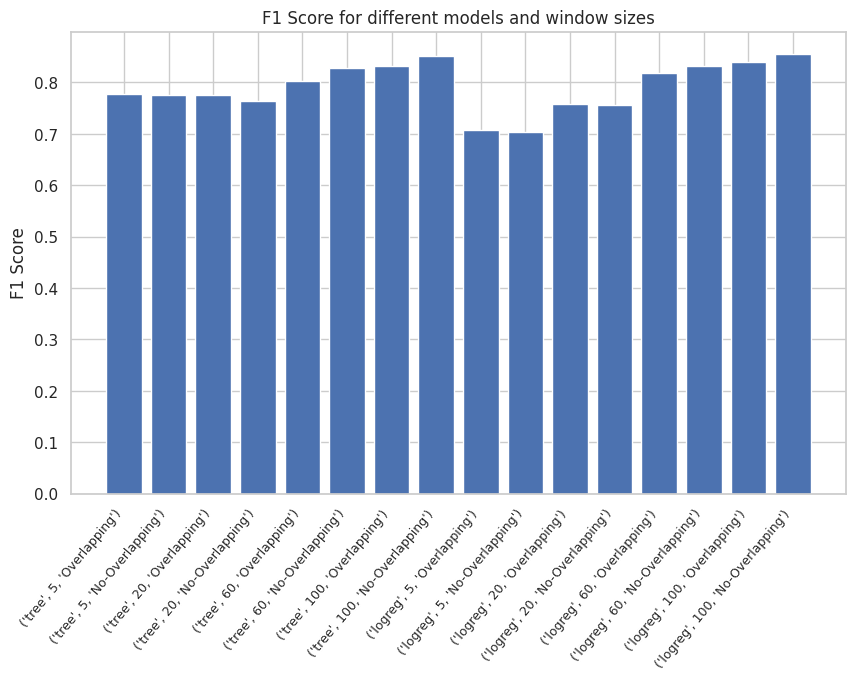

In [106]:
experiments = final_f1_results.keys()
f1_scores = final_f1_results.values()

plt.figure(figsize=(10, 6))
plt.bar(range(len(experiments)), f1_scores, align='center')
plt.xticks(range(len(experiments)), experiments, rotation=50, ha='right', fontsize=9)
plt.ylabel('F1 Score')
plt.title('F1 Score for different models and window sizes')
plt.show()

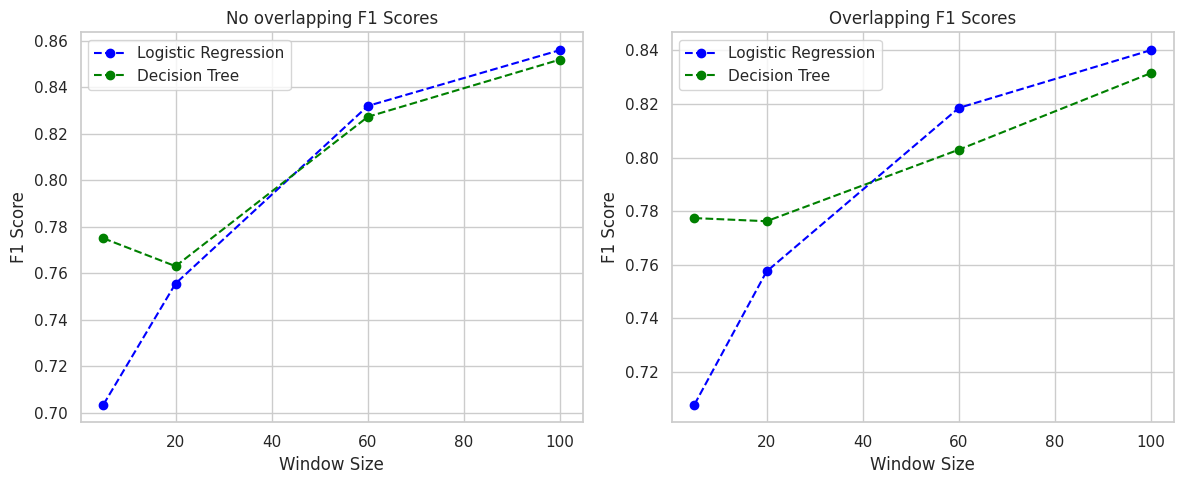

In [67]:
no_overlapping_logreg_f1s = [final_f1_results[("logreg", ws, "No-Overlapping")] for ws in window_size] 
no_overlapping_tree_f1s = [final_f1_results[("tree", ws, "No-Overlapping")] for ws in window_size]

overlapping_logreg_f1s = [final_f1_results[("logreg", ws, "Overlapping")] for ws in window_size]
overlapping_tree_f1s = [final_f1_results[("tree", ws, "Overlapping")] for ws in window_size]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# No overlapping
axes[0].plot(window_size, no_overlapping_logreg_f1s, marker="o", markersize=6, linestyle="--", label="Logistic Regression", color="blue")
axes[0].plot(window_size, no_overlapping_tree_f1s, marker="o", markersize=6, linestyle="--", label="Decision Tree", color="green")
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('No overlapping F1 Scores')
axes[0].legend()
axes[0].grid(True)

# Overlapping
axes[1].plot(window_size, overlapping_logreg_f1s, marker="o", markersize=6, linestyle="--", label="Logistic Regression", color="blue")
axes[1].plot(window_size, overlapping_tree_f1s, marker="o", markersize=6, linestyle="--", label="Decision Tree", color="green")
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Overlapping F1 Scores')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

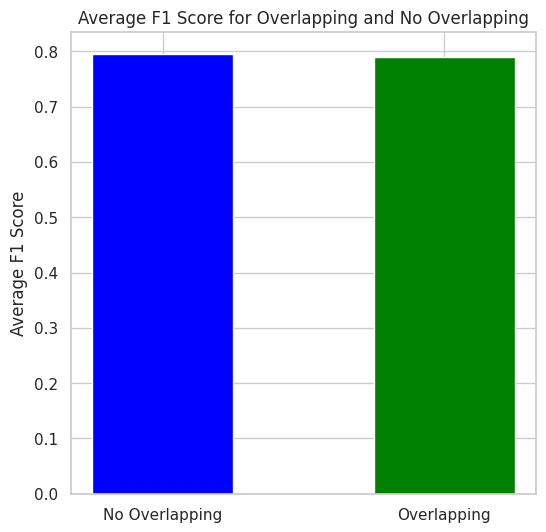

In [ ]:
mean_no_overlapping = np.mean(no_overlapping_logreg_f1s + no_overlapping_tree_f1s)
mean_overlapping = np.mean(overlapping_logreg_f1s + overlapping_tree_f1s)

fig, ax = plt.subplots(figsize=(6, 6))

categories = ['No Overlapping', 'Overlapping']
means = [mean_no_overlapping, mean_overlapping]

ax.bar(categories, means, color=['blue', 'green'], width=0.5)

ax.set_ylabel('Average F1 Score')
ax.set_title('Average F1 Score for Overlapping and No Overlapping')

plt.show()

---

## Results Analysis

The F1 Score is a metric used to evaluate the performance of a classification model. This metric balances two key aspects:

- Precision – How many of the predicted positive cases are actually correct.
- Recall – How many of the actual positive cases did the model successfully detect.

By combining these two elements into a single value, the F1 Score provides a measure of a model’s overall performance. The higher the F1 Score, the better the model’s performance, as it indicates both accuracy in predictions and success in detecting relevant cases.

In this context, the two first graphs above display the F1 Scores obtained for different models (logistic regression and decision tree), sliding window configurations (overlapping and non-overlapping), and window sizes (5, 20, 60, and 100).

To begin with, the logistic regression model (logreg) tends to outperform the decision tree (tree), particularly with larger window sizes (60, 100). However, for smaller window sizes (5, 20), the decision tree performs slightly better. 

Moreover, larger window sizes improve the F1 Score for both models, indicating that having more context from previous time instances helps the models make better predictions, giving better and overall highest F1 scores in the logreg model, as previosuly mentioned. However, increasing the window size more may lead to diminishing returns or potential overfitting, as can be expected from the graphs' slopes.

Additionally, for smaller window sizes, overlapping windows tend to improve performance by providing smoother transitions and more training samples. However, for larger window sizes, non-overlapping windows perform better, possibly because they introduce more variation into the training data and prevent redundant information from affecting the model’s learning process.

Finally, the third and last plot shows the average F1 score of the logistic regression and the decision tree models, comparing the overlapping and non-overlapping sliding windows configurations. Again, the plot suggests that using non-overlapping windows provide a better performance, although the mean scores are quite similar for both window configurations.

In conclusion, by analyzing the F1 Scores across all configurations, the best classification model is the logistic regression model with non-overlapping windows of size 100. This configuration achieves the highest F1 Score, making it the most effective for predicting driving maneuvers in this dataset. For this reason, this was the model configuration selected for the final model.